### Improving Plots and Sharing Findings

In [2]:
# Import libraries
import unicodecsv
from datetime import datetime as dt

In [3]:
# Create functions

# Open csv files and convert to list
def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)
    
# Return a bool type that represent if the student's engagement is 
# in first week of program
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days >= 0 and time_delta.days < 7

# Return new list without the trial students
def remove_free_trial_cancels(data, list_paid_students):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in list_paid_students:
            new_data.append(data_point)
    return new_data

In [4]:
# Set data in variables
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

In [5]:
# Rename column acct to account_key in enrollments list
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del[engagement_record['acct']]

In [6]:
list_students_udacity = set()
non_udacity_enrollments = []

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    if enrollment['is_udacity'] == 'False':
        enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
        enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
        enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
        enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
        enrollment['join_date'] = parse_date(enrollment['join_date'])
        non_udacity_enrollments.append(enrollment)
    else:
        list_students_udacity.add(enrollment['account_key'])

In [7]:
non_udacity_engagement = []

# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    if engagement_record['account_key'] not in list_students_udacity:
        engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
        engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
        engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
        engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
        engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
        non_udacity_engagement.append(engagement_record)
    

In [8]:
non_udacity_submissions = []

# Clean up the data types in the submissions table
for submission in project_submissions:
    if submission['account_key'] not in list_students_udacity:
        submission['completion_date'] = parse_date(submission['completion_date'])
        submission['creation_date'] = parse_date(submission['creation_date'])
        non_udacity_submissions.append(submission)


In [9]:
paid_students = {}
for enrollment in non_udacity_enrollments:
    if (not enrollment['is_canceled'] or
            enrollment['days_to_cancel'] > 7):
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        if (account_key not in paid_students or
                enrollment_date > paid_students[account_key]):
            paid_students[account_key] = enrollment_date

print("Total of paid students: " + str(len(paid_students)))

Total of paid students: 995


In [10]:
print ("Paid students and trial students: " + str(len(non_udacity_enrollments)))
print ("Paid students and trial students: " + str(len(non_udacity_engagement)))
print ("Paid students and trial students: " + str(len(non_udacity_submissions)))

paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments, paid_students)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement, paid_students)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions, paid_students)

print ("Only paid students: " + str(len(paid_enrollments)))
print ("Only paid students: " + str(len(paid_engagement)))
print ("Only paid students: " + str(len(paid_submissions)))

Paid students and trial students: 1622
Paid students and trial students: 135656
Paid students and trial students: 3634
Only paid students: 1293
Only paid students: 134549
Only paid students: 3618


In [11]:
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [12]:
paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']

    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)

print("Engagement of paid students in first week: " + str(len(paid_engagement_in_first_week)))

Engagement of paid students in first week: 6919


In [13]:
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

In [14]:
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

In [66]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def describe_data(data, title): 
    print ('Mean:', np.mean(list(data)))
    print ('Standard deviation:', np.std(list(data)))
    print ('Minimum:', np.min(list(data)))
    print ('Maximum:', np.max(list(data)))
    plt.hist(list(data), bins=8)
    plt.xlabel('Number of days')
    plt.title(title)
    


Populating the interactive namespace from numpy and matplotlib


Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


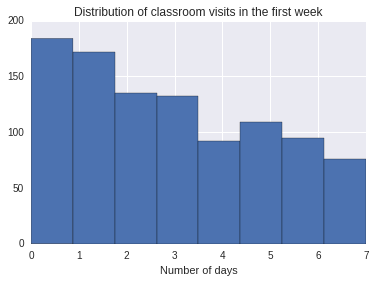

In [67]:
engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')

lessons_completed_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
describe_data(lessons_completed_by_account.values(), 'Distribution of classroom visits in the first week')

In [68]:
paid_submissions[2]

{'account_key': '256',
 'assigned_rating': 'PASSED',
 'completion_date': datetime.datetime(2015, 1, 20, 0, 0),
 'creation_date': datetime.datetime(2015, 1, 20, 0, 0),
 'lesson_key': '3176718735',
 'processing_state': 'EVALUATED'}

In [69]:
subway_project_lesson_keys = ['746169184','3176718735']
pass_subway_project = set()

for submissions in paid_submissions:
    if submissions['lesson_key'] in subway_project_lesson_keys:
        if submissions['assigned_rating'] == 'PASSED' or submissions['assigned_rating'] == 'DISTINCTION':
            pass_subway_project.add(submissions['account_key'])

print(len(pass_subway_project))
print(len(paid_engagement_in_first_week))

list_passing_engagement = []
list_non_passing_engagement = []   
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        list_passing_engagement.append(engagement_record)
    else:
        list_non_passing_engagement.append(engagement_record)

passing_engagement = len(list_passing_engagement)
non_passing_engagement = len(list_non_passing_engagement)

print(passing_engagement)
print(non_passing_engagement)

647
6919
4527
2392


In [70]:
list_passing_engagement[0]

{'account_key': '0',
 'has_visited': 1,
 'lessons_completed': 0,
 'num_courses_visited': 1,
 'projects_completed': 0,
 'total_minutes_visited': 11.6793745,
 'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

Days visited
non-passing students:
Mean: 1.90517241379
Standard deviation: 1.90573144136
Minimum: 0
Maximum: 7


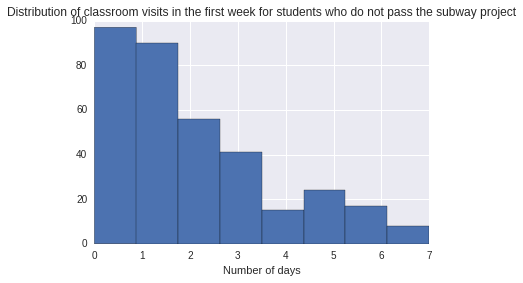

In [71]:
print ('Days visited')
print ('non-passing students:')
non_passing_engagement_by_account = group_data(list_non_passing_engagement, 'account_key')
non_passing_visits = sum_grouped_items(non_passing_engagement_by_account,'has_visited')
describe_data(non_passing_visits.values(), 'Distribution of classroom visits in the first week ' +
             'for students who do not pass the subway project')


passing students:
Mean: 3.38485316847
Standard deviation: 2.25882147092
Minimum: 0
Maximum: 7


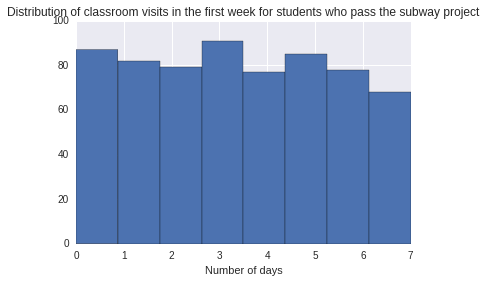

In [72]:
print ('passing students:')
passing_engagement_by_account = group_data(list_passing_engagement, 'account_key')
passing_visits = sum_grouped_items(passing_engagement_by_account,'has_visited')
describe_data(passing_visits.values(),'Distribution of classroom visits in the first week ' +
              'for students who pass the subway project')

Minutes spend
non-passing students:
Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


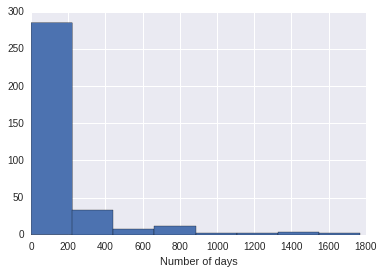

In [74]:
print ('Minutes spend')
print ('non-passing students:')
non_passing_engagement_by_account = group_data(list_non_passing_engagement, 'account_key')
non_passing_visits = sum_grouped_items(non_passing_engagement_by_account,'total_minutes_visited')
describe_data(non_passing_visits.values(), '')


passing students:
Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645


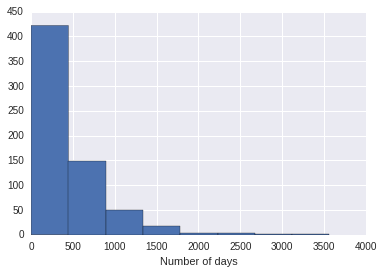

In [75]:
print ('passing students:')
passing_engagement_by_account = group_data(list_passing_engagement, 'account_key')
passing_visits = sum_grouped_items(passing_engagement_by_account,'total_minutes_visited')
describe_data(passing_visits.values(), '')

lessons completed
non-passing students:
Mean: 0.862068965517
Standard deviation: 2.54915994183
Minimum: 0
Maximum: 27


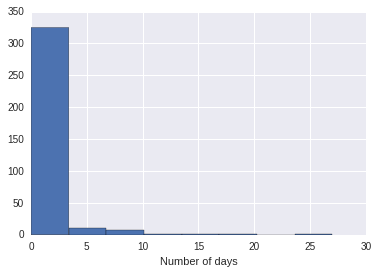

In [76]:
print ('lessons completed')
print ('non-passing students:')
non_passing_engagement_by_account = group_data(list_non_passing_engagement, 'account_key')
non_passing_visits = sum_grouped_items(non_passing_engagement_by_account,'lessons_completed')
describe_data(non_passing_visits.values(), '')


passing students:
Mean: 2.05255023184
Standard deviation: 3.14222705558
Minimum: 0
Maximum: 36


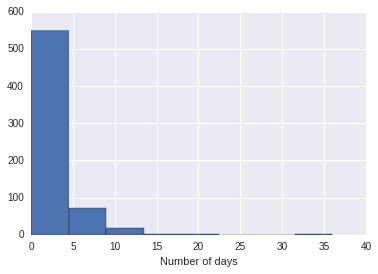

In [77]:
print ('passing students:')
passing_engagement_by_account = group_data(list_passing_engagement, 'account_key')
passing_visits = sum_grouped_items(passing_engagement_by_account,'lessons_completed')
describe_data(passing_visits.values(), '')